# Consultas y Visualización

Lo primero que haré sera importar las librerías que pienso utilizar a lo largo del proyecto.

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import mysql.connector


Creo la variable 'estadios', con el conector hacia la base de datos en MySQL y chequeo que la conexión este establecida.

In [77]:
estadios = mysql.connector.connect(host="localhost", user="root", passwd="julieta2809",database="estadios")

if estadios.is_connected():
    print("Conexión establecida correctamente.")
else:
    print("Problemas con la conexión.")
    

Conexión establecida correctamente.


Creo el cursor con el que realizaré consultas a mi base de datos.

In [78]:
cursor = estadios.cursor()

## Gráfico de barras

En esta primera consulta, busco saber la capacidad total de los estadios, por confederación.

In [79]:
cursor.execute("""SELECT confederation AS Confederacion, SUM(capacity) AS Capacidad
               FROM estadios_tres_confederaciones 
               GROUP BY confederation 
               ORDER BY SUM(capacity) DESC""") 
               
capacidad_por_confedereacion = cursor.fetchall()

for i in capacidad_por_confedereacion:
    print (i)

('UEFA', Decimal('20158727'))
('CONCACAF', Decimal('9001050'))
('CONMEBOL', Decimal('4223002'))


Creo data frame con la información de la consulta anterior, para poder proceder a graficar.

In [80]:
# Utilizo el bucle for para poder obtener el header de cada columna.

capacidad_df = pd.DataFrame(capacidad_por_confedereacion, columns=[i[0] for i in cursor.description])

capacidad_df



,Confederacion,Capacidad
0,UEFA,20158727
1,CONCACAF,9001050
2,CONMEBOL,4223002


Realizo un gráfico de barras, creo que este dataframe es pequeño y se vera bien reflejado en este tipo de gráfico.

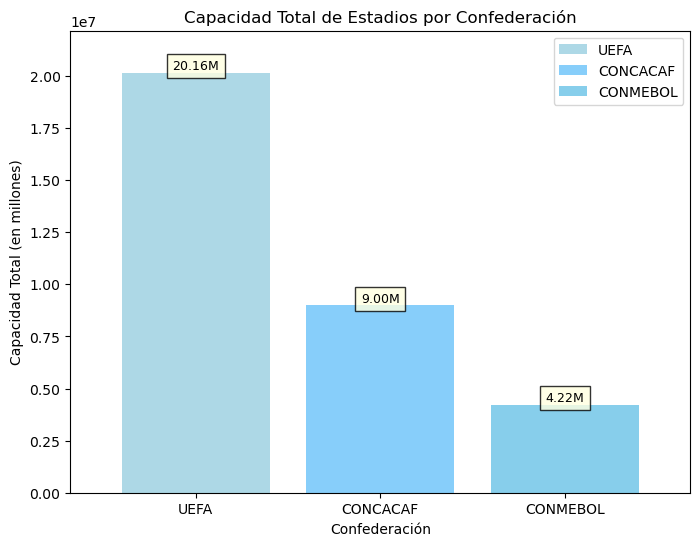

In [107]:
# Me aseguro de que los datos dentro de la columna 'Capacidad' sean enteros, y sino que sean convertidos.
# Esto es para poder realizar operaciones posteriormente.

capacidad_df['Capacidad'] = capacidad_df['Capacidad'].astype(int)

# Comienzo a crear el gráfico.

plt.figure(figsize=(8, 6))
bars = plt.bar(capacidad_df['Confederacion'], capacidad_df['Capacidad'], color=['lightblue', 'lightskyblue', 'skyblue'])
plt.xlabel('Confederación')
plt.ylabel('Capacidad Total (en millones)')
plt.title('Capacidad Total de Estadios por Confederación')
plt.margins(0.1)
plt.legend(bars, capacidad_df['Confederacion'])

# Con el siguiente bucle, busco poner los valores encima de cada barra, mejora la visualización y da valor concreto.

for i, valor in enumerate(capacidad_df['Capacidad']):
    plt.text(i, valor, f'{valor/1e6:.2f}M', ha='center', va='bottom', color='black', fontsize=9, 
             bbox = dict(facecolor = 'lightyellow', alpha =.8))

plt.savefig('grafico_barras_1.png', bbox_inches='tight')
plt.show()

## Pie Chart

En esta oportunidad también se puede utilizar un gráfico de torta para ver como esta distribuida la capacidad total de las tres
confederaciones.

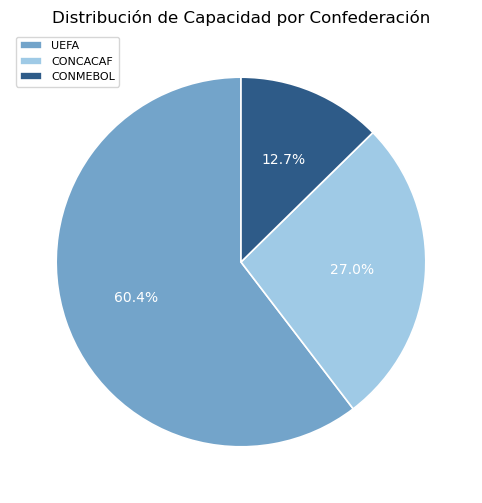

In [106]:
plt.figure(figsize=(8,6))
plt.pie(capacidad_df['Capacidad'],
        startangle = 90, autopct = '%1.1f%%', colors=["#73A4CA", "#9FCAE6", "#2E5B88"], 
        wedgeprops = {"linewidth": 1.2, "edgecolor": "white"},textprops={'color': 'white'})

plt.legend(capacidad_df['Confederacion'],loc='upper left', fontsize=8)
plt.title('Distribución de Capacidad por Confederación')
plt.savefig('pie_chart_1.png', bbox_inches='tight');

## Tree Map

Creo una segunda consulta, donde buscare saber la capacidad total de estadios de los distintos países de la federación CONMEBOL.

In [85]:
cursor.execute("""SELECT country AS País, SUM(capacity) AS Capacidad 
               FROM estadios_tres_confederaciones 
               WHERE confederation = 'conmebol' 
               GROUP BY country 
               ORDER BY SUM(capacity) DESC""") 
               
capacidades_conmebol = cursor.fetchall()

for i in capacidades_conmebol:
    print (i)

('Brazil', Decimal('1614462'))
('Argentina', Decimal('746576'))
('Chile', Decimal('401683'))
('Venezuela', Decimal('361597'))
('Colombia', Decimal('286529'))
('Peru', Decimal('216661'))
('Paraguay', Decimal('187000'))
('Ecuador', Decimal('180754'))
('Uruguay', Decimal('137740'))
('Bolivia', Decimal('90000'))


Vuelvo a crear un data frame con la información de la consulta anterior, para poder proceder a graficar.

In [87]:
capacidades_conmebol_df = pd.DataFrame(capacidades_conmebol, columns=[i[0] for i in cursor.description])

In [88]:
capacidades_conmebol_df

,País,Capacidad
0,Brazil,1614462
1,Argentina,746576
2,Chile,401683
3,Venezuela,361597
4,Colombia,286529
5,Peru,216661
6,Paraguay,187000
7,Ecuador,180754
8,Uruguay,137740
9,Bolivia,90000


Para visualizar el data frame anterior, utilizaré un TreeMap que permitira visualizar la proporción de cada país.

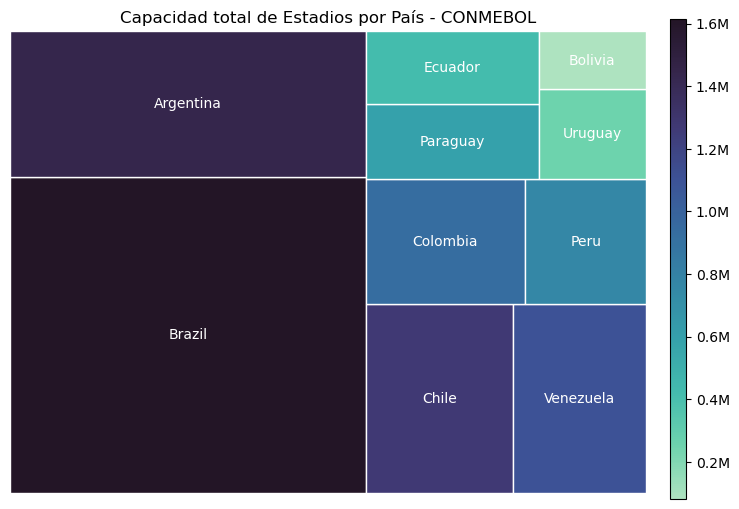

In [105]:
# Para realizar este tipo de gráficos necesito importar squarify que se utilizará en conjunto con matplotlib. Además, importaré
# seaborn para  utilizar una paleta de colores.

import squarify
import seaborn as sb
import matplotlib.colorbar as mcolorbar
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8,6))

capacidades_conmebol_df['Capacidad'] = capacidades_conmebol_df['Capacidad'].astype(float)

plt.title('Capacidad total de Estadios por País - CONMEBOL')

# Le doy forma al gráfico, indicando el criterio de tamaño de los cuadrados, etiquetas con los nombres de los países, 
# paleta de colores utilizando "mako" de seaborn, entre otros.

squarify.plot(sizes = capacidades_conmebol_df['Capacidad'], 
              text_kwargs = {'fontsize': 10, 'color': 'white'},
              label= capacidades_conmebol_df['País'],
              color = sb.color_palette("mako", len(capacidades_conmebol_df['País'])),
              linewidth=1,
              edgecolor='white'
             )

# Elimino los ejes para una mejor visualización.

plt.axis("off")

# Las siguientes líneas son para crear la barra de colores y que me quede de acuerdo a lo visto en el TreeMap. Esta barra es
# independiente al gráfico. Al crearla tuve un problema y fue que los valores estaban invertidos, es decir que los colores más
# claros representaban los valores más altos y vicebersa. Con una pequeña búsqueda y una serie de intentos, logre que
# quede de forma correcta.

# Cambiar la normalización para invertir la barra de colores
norm = Normalize(vmin=capacidades_conmebol_df['Capacidad'].max(), vmax=capacidades_conmebol_df['Capacidad'].min())

# Obtener la paleta de colores "mako" y revertirla
inverted_palette = sb.color_palette("mako", len(capacidades_conmebol_df['País']))[::-1]

# Crear el colormap invertido
inverted_cmap = LinearSegmentedColormap.from_list('inverted_mako', inverted_palette)

# Crear la barra de colores con la normalización invertida
cbar = mcolorbar.ColorbarBase(plt.axes([0.95, 0.1, 0.02, 0.8]), cmap=inverted_cmap, norm=norm, orientation='vertical')

# Borro la notación científica de la barra de colores y agrego la "M".
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.subplots_adjust(right=0.92) # Arrimo la barra de colores hacia el grafico, por motivos de guardado.

plt.savefig('treemap_1.png', bbox_inches='tight') # Además de guardar, aseguro que se guarde la barra de colores.

## Gráfico de barras horizontal

Otra manera de representar los resultados de la consulta es a través de un gráfico de barras horizontal.

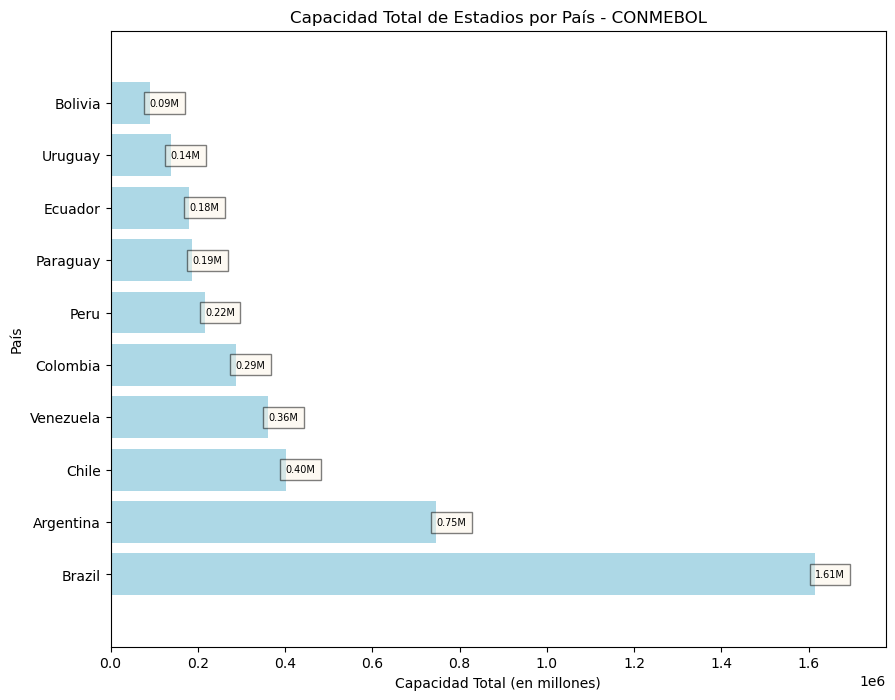

In [108]:
# Como en el gráfico de barras creado anteriormente, me aseguro de que los datos dentro de la columna 'Capacidad' 
#sean enteros, y sino que sean convertidos. Esto es para poder realizar operaciones posteriormente en el bucle.

capacidades_conmebol_df['Capacidad'] = capacidades_conmebol_df['Capacidad'].astype(int)

plt.figure(figsize=(10, 8))
bars = plt.barh(capacidades_conmebol_df['País'], capacidades_conmebol_df['Capacidad'], color = 'lightblue')

plt.xlabel('Capacidad Total (en millones)')
plt.ylabel('País')
plt.title('Capacidad Total de Estadios por País - CONMEBOL')
plt.margins(0.1)

# Vuelvo a utilizar el bucle for para crear las etiquetas. Utilizo bbox para que las etiquetas esten dentro de una caja.

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()/1e6:.2f}M',
             va='center', ha='left', color='black', fontsize=7, bbox = {'facecolor': 'oldlace', 'alpha': 0.5})

plt.savefig('grafico_hbarras_1.png', bbox_inches='tight')
plt.show()

## Scatter Plot

Realizo una nueva consulta a la base de datos, en esta oportunidad busco comparar la población de los países con su capacidad en los estadios.

In [45]:
cursor.execute("""SELECT 
               country AS País, 
               SUM(capacity) AS Capacidad, 
               AVG(population) AS Poblacion 
               FROM estadios_tres_confederaciones 
               GROUP BY country 
               ORDER BY AVG(population) DESC""") 
               
capacidad_vs_poblacion = cursor.fetchall()

for i in capacidad_vs_poblacion:
    print (i)

('United States of America', Decimal('7150367'), Decimal('325719178.0000'))
('Brazil', Decimal('1614462'), Decimal('210147125.0000'))
('Russia', Decimal('1066224'), Decimal('144526636.0000'))
('Mexico', Decimal('1022560'), Decimal('133140936.0000'))
('Germany', Decimal('2453107'), Decimal('82800000.0000'))
('Turkey', Decimal('849098'), Decimal('80810525.0000'))
('France', Decimal('1427886'), Decimal('67348000.0000'))
('Italy', Decimal('1323616'), Decimal('60483973.0000'))
('England', Decimal('2383457'), Decimal('55619400.0000'))
('Colombia', Decimal('286529'), Decimal('49996445.0000'))
('Spain', Decimal('1686729'), Decimal('46710000.0000'))
('Argentina', Decimal('746576'), Decimal('43847430.0000'))
('Ukraine', Decimal('588981'), Decimal('42418235.0000'))
('Poland', Decimal('842187'), Decimal('38433600.0000'))
('Canada', Decimal('496496'), Decimal('37067011.0000'))
('Peru', Decimal('216661'), Decimal('32162184.0000'))
('Venezuela', Decimal('361597'), Decimal('31568179.0000'))
('Romania'

Creo data frame con los resultados obtenidos en la consultas anteriores.

In [46]:
capacidad_vs_poblacion_df = pd.DataFrame(capacidad_vs_poblacion, columns=[i[0] for i in cursor.description])

capacidad_vs_poblacion_df

,País,Capacidad,Poblacion
0,United States of America,7150367,325719178.0000
1,Brazil,1614462,210147125.0000
2,Russia,1066224,144526636.0000
3,Mexico,1022560,133140936.0000
4,Germany,2453107,82800000.0000
...,...,...,...
63,Malta,21029,475700.0000
64,Iceland,40077,355620.0000
65,Greenland,2500,55877.0000
66,Faroe Islands,26240,51095.0000


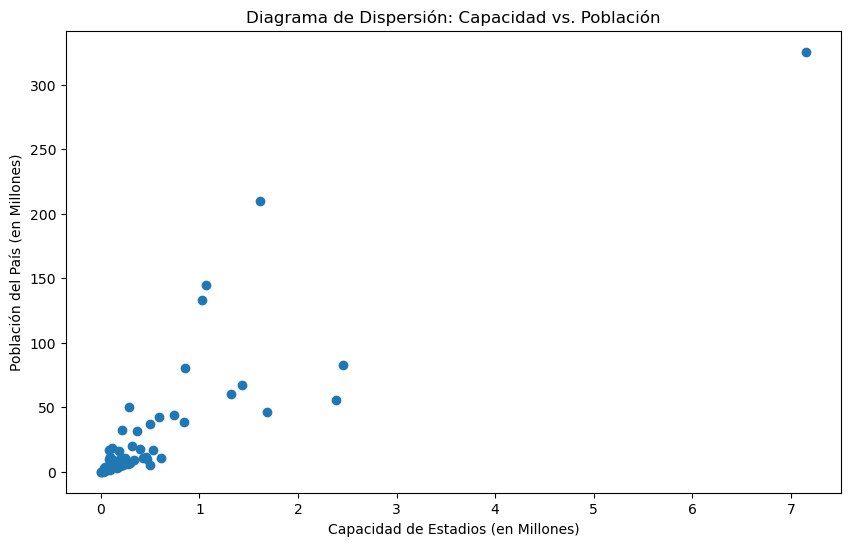

In [47]:
plt.figure(figsize=(10, 6))

# Comienzo a realizar el gráfico. Divido las cantidades en los ejes para mostrar la información en nmillones. A modo de
# visualización es más prolijo y facilita la lectura.

plt.scatter(capacidad_vs_poblacion_df['Capacidad']/1000000, 
            capacidad_vs_poblacion_df['Poblacion']/1000000)

plt.xlabel('Capacidad de Estadios (en Millones)')
plt.ylabel('Población del País (en Millones)')
plt.title('Diagrama de Dispersión: Capacidad vs. Población')

# Elimino la notación científica de los ejes.
plt.ticklabel_format(style='plain', useOffset=False, axis='both')

plt.show()

# Como se puede observar, el gráfico aún se puede mejorar.

Creo una columna nueva dentro del data frame, que se llamara 'Poblacion_normalizada'. El objetivo es darle tamaño a los globos, pero de una forma correcta y proporcional que facilite la visualización.

In [48]:
capacidad_vs_poblacion_df['Poblacion_normalizada'] = capacidad_vs_poblacion_df['Poblacion']/(max(capacidad_vs_poblacion_df['Poblacion'])/10000)
capacidad_vs_poblacion_df

,País,Capacidad,Poblacion,Poblacion_normalizada
0,United States of America,7150367,325719178.0000,10000
1,Brazil,1614462,210147125.0000,6451.788509671358681864289858
2,Russia,1066224,144526636.0000,4437.154633860705616787476972
3,Mexico,1022560,133140936.0000,4087.598919336582631311933373
4,Germany,2453107,82800000.0000,2542.067080864363473249339958
...,...,...,...,...
63,Malta,21029,475700.0000,14.60460519767122831189264514
64,Iceland,40077,355620.0000,10.91799390455295819271654922
65,Greenland,2500,55877.0000,1.715496162771232340516345034
66,Faroe Islands,26240,51095.0000,1.568682578463341203691727357


Me aseguro de que los valores de las columnas Capacidad, Poblacion y Poblacion_normalizada tengan valor númerico.

In [49]:
capacidad_vs_poblacion_df['Capacidad'] = pd.to_numeric(capacidad_vs_poblacion_df['Capacidad'], errors='coerce') 
capacidad_vs_poblacion_df['Poblacion'] = pd.to_numeric(capacidad_vs_poblacion_df['Poblacion'], errors='coerce')
capacidad_vs_poblacion_df['Poblacion_normalizada'] = pd.to_numeric(capacidad_vs_poblacion_df['Poblacion_normalizada'], errors='coerce')

capacidad_vs_poblacion_df.info()

# El parámetro 'errors='coerce' se utiliza para que en el caso de algún error durante la conversión, pandas asigne 
# valor NaN (Not a Number) en lugar de lanzar una excepción o detener la operación.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   País                   68 non-null     object 
 1   Capacidad              68 non-null     float64
 2   Poblacion              68 non-null     float64
 3   Poblacion_normalizada  68 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.3+ KB


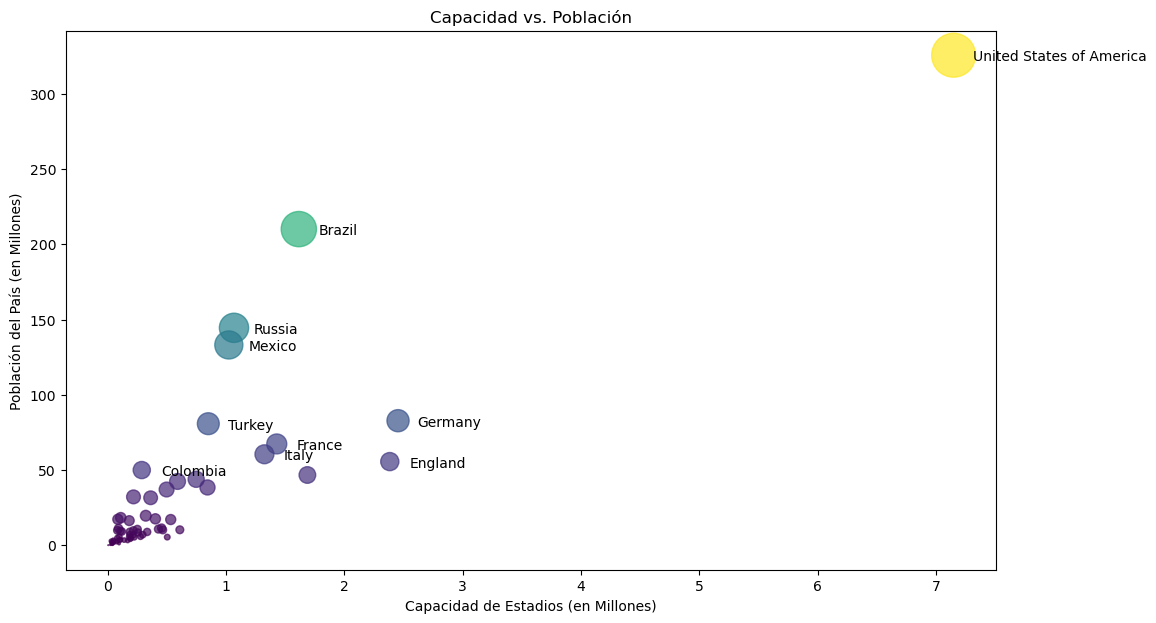

In [109]:
# Mejoro un poco más el gráfico, se le agrega transparencia, tamaño y color a los globos.

plt.figure(figsize=(12, 7))
scatter_estadios = plt.scatter(capacidad_vs_poblacion_df['Capacidad']/1000000, 
                    capacidad_vs_poblacion_df['Poblacion']/1000000, 
                    alpha=0.7, # transparencia
                    s= capacidad_vs_poblacion_df['Poblacion_normalizada']/10, # tamaño
                    c=capacidad_vs_poblacion_df['Poblacion_normalizada']) #color

plt.xlabel('Capacidad de Estadios (en Millones)')
plt.ylabel('Población del País (en Millones)')
plt.title('Capacidad vs. Población')

# Elimino notación científica.
plt.ticklabel_format(style='plain', useOffset=False, axis='both')

# Utilizo bucle for para etiquetar los nombres de los 10 países con mayor población.
for i in range(10):
    plt.annotate(capacidad_vs_poblacion_df['País'][i],
                 xy=(capacidad_vs_poblacion_df['Capacidad'][i] / 1000000,
                     capacidad_vs_poblacion_df['Poblacion'][i] / 1000000),
                 xytext=(14, -4), textcoords='offset points')

plt.savefig('scatterplot_1.png', bbox_inches='tight')
plt.show()

## Gráfico de barras

Realizo una nueva consulta para ver cuales son los 3 estadios con mayor capacidad en cada confederación.

In [51]:
cursor.execute("""WITH RankingEstadios AS 
               (SELECT confederation, country, stadium, capacity, 
                ROW_NUMBER() OVER (PARTITION BY confederation ORDER BY capacity DESC) 
                AS row_num FROM estadios_tres_confederaciones) 
               SELECT confederation AS Confederacion, country AS Pais, stadium AS Estadio, capacity AS Capacidad 
               FROM RankingEstadios 
               WHERE row_num <= 3""") 
               
ranking_estadios = cursor.fetchall()

for i in ranking_estadios:
    print (i)

('CONCACAF', 'United States of America', 'Bristol Motor Speedway', 153000)
('CONCACAF', 'United States of America', 'Michigan Stadium', 107601)
('CONCACAF', 'United States of America', 'Beaver Stadium', 106572)
('CONMEBOL', 'Peru', 'Estadio Teodoro Lolo Fernández', 80093)
('CONMEBOL', 'Brazil', 'Maracanã', 78838)
('CONMEBOL', 'Brazil', 'Estádio Nacional', 72888)
('UEFA', 'Spain', 'Camp Nou', 99354)
('UEFA', 'England', 'Wembley', 90652)
('UEFA', 'Spain', 'Estadio Santiago Bernabéu', 85454)


In [52]:
ranking_estadios_df = pd.DataFrame(ranking_estadios, columns=[i[0] for i in cursor.description])

ranking_estadios_df

,Confederacion,Pais,Estadio,Capacidad
0,CONCACAF,United States of America,Bristol Motor Speedway,153000
1,CONCACAF,United States of America,Michigan Stadium,107601
2,CONCACAF,United States of America,Beaver Stadium,106572
3,CONMEBOL,Peru,Estadio Teodoro Lolo Fernández,80093
4,CONMEBOL,Brazil,Maracanã,78838
5,CONMEBOL,Brazil,Estádio Nacional,72888
6,UEFA,Spain,Camp Nou,99354
7,UEFA,England,Wembley,90652
8,UEFA,Spain,Estadio Santiago Bernabéu,85454


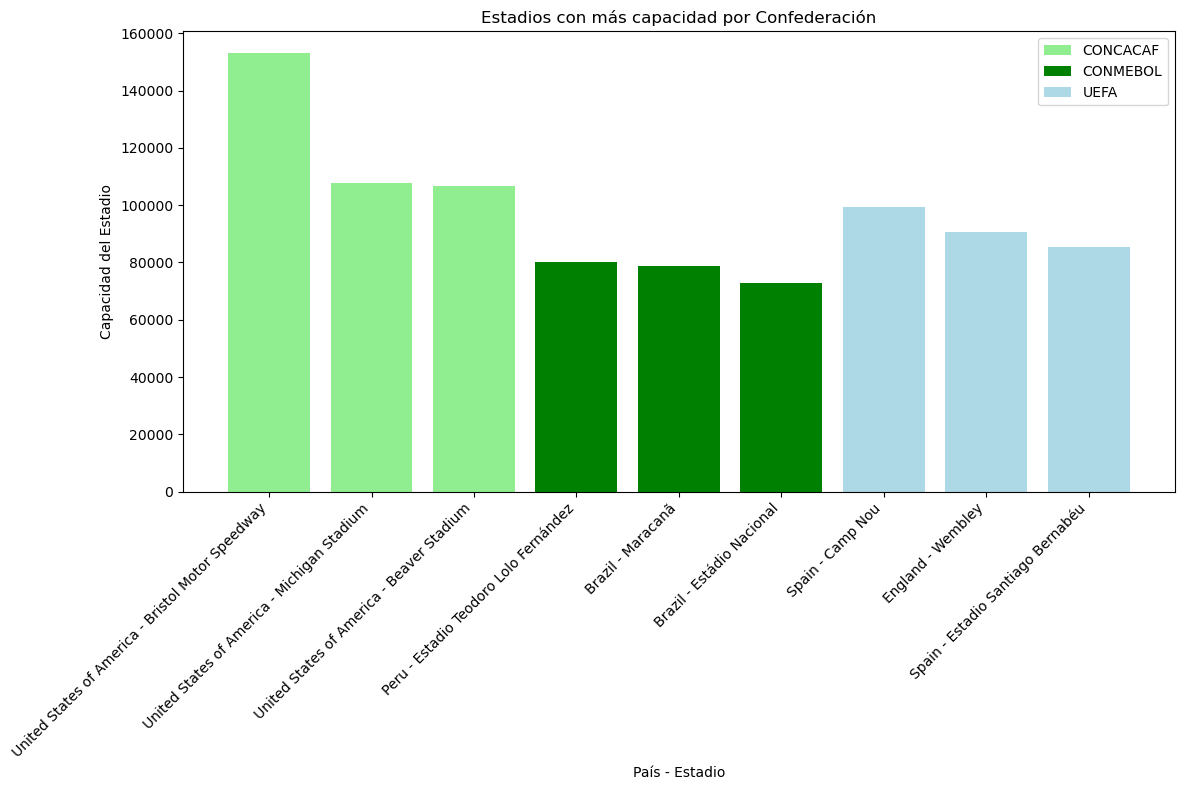

In [110]:
plt.figure(figsize=(12, 8))
colors = {'CONCACAF': 'lightgreen', 'CONMEBOL': 'green', 'UEFA': 'lightblue'} 

# En este caso cree la variable colors para asignarle un color a cada confederación.

# Utilizo un bucle for para asignarle nombre de estadio y  país a cada barra.

for confederation, group_df in ranking_estadios_df.groupby('Confederacion'):
    plt.bar(group_df['Pais'] + ' - ' + group_df['Estadio'], group_df['Capacidad'], label=confederation, color=colors[confederation])

plt.xlabel('País - Estadio')
plt.ylabel('Capacidad del Estadio')
plt.title('Estadios con más capacidad por Confederación')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Utilizo este metodo para darle una inclinación a los nombres y se puedan leer mejor.
plt.tight_layout()

plt.savefig('grafico_barras_2.png', bbox_inches='tight')
plt.show()

Cierro cursor y conexión a la base de datos.

In [111]:
cursor.close()

True

In [112]:
estadios.close()

In [70]:
!git add Consultas_Visualización.ipynb

In [71]:
!git commit -m "Últimos detalles."

[main d9987fb] Ãšltimos detalles.
 1 file changed, 26 insertions(+), 13 deletions(-)


In [72]:
!git push

remote: This repository moved. Please use the new location:        
remote:   https://github.com/guilleldas/Proyecto_Visualizacion_Python.git        
To https://github.com/guilleldas/Proyecto_SQL_Python.git
   118f0d7..d9987fb  main -> main
